# Temporal Aggregation of Single Landsat Scenes to create Multi-Temporal Landsat Composites

In remote sensing, we usually work on single images ("scenes") acquired on a given date over a given area. While this sufficient or even necessary for many applications such as the studying of vegetation dynamics, some applications actually require information combined from many scenes, i.e., multiple "snapshots" of an area over time.

Single scenes tend to be noisy mostly because of atmospheric disturbances and instrumentation errors. Thus single scenes might contain significant parts of no-data or poor-quality pixels due to instrument failures, clouds (in the case of optical imagery) or shadows. Taking multiple scenes acquired at different points in time and aggregating them over time by a statistical measure such as the mean or median is therefore in some cases the preferred choice.

Multi-temporal composites are used for many different applications, including

* inputs for classification tasks such as land use/ land cover mapping
* generation of equidistant time series
* generation of basemaps

In this notebook, you will learn how to generate a multi-temporal mosaic
The steps are:

1. Fetch the Landsat scenes overlapping the study region
2. Aggregate the Landsat scenes into a single multi-temporal composite using the median, mean, mnedian absolute deviation (mad) and coefficent of variance (cov) as well as some spectral indices on the basis of the median bands.

This code was written by Finn Timcke and is based on a notebook by Dr. Lukas Valentin Graf (https://github.com/terensis-dev/eodal_tutorials/blob/main/01_general/04_Multitemporal_Composites.ipynb).


# Imports and Functions

In [3]:
# we have to install the development version for the time being
#%pip uninstall eodal -y
#%pip install git+https://github.com/lukasValentin/eodal@landsat-dev
#%pip install openpyxl

# required imports
import os
from datetime import datetime
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from pathlib import Path
import geopandas as gpd
import pandas as pd
from eodal.config import get_settings
from eodal.core.sensors import Landsat
from eodal.core.scene import SceneCollection
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import Mapper, MapperConfigs
from eodal.core.band import Band
from eodal.core.raster import RasterCollection


# the function to mask clouds and shadows:
def prepocess_landsat_scene(
        ds: Landsat
) -> Landsat:
    """
    Mask clouds and cloud shadows in a Landsat scene based
    on the 'qa_pixel' band.

    NOTE:
        Depending on your needs, the pre-processing function can be
        fully customized using the full power of EOdal and its
        interfacing libraries!

    :param ds:
        Landsat scene before cloud mask applied.
    :return:
        Landsat scene with clouds and cloud shadows masked.
    """
    ds.mask_clouds_and_shadows(inplace=True)
    return ds

# functions to plot:
def scatterplot_temporal_distribution(metadata_gdf, save_path, year):

    # Convert lists in 'instruments' column to strings
    metadata_gdf['instruments_str'] = metadata_gdf['instruments'].apply(lambda x: ', '.join(map(str, x)))
    #filtered_metadata_gdf['instruments_str'] = filtered_metadata_gdf['instruments'].apply(lambda x: ', '.join(map(str, x)))
    
    # Convert 'sensing_date' to datetime type if it's not already
    metadata_gdf['sensing_date'] = pd.to_datetime(metadata_gdf['sensing_date'], errors='coerce')
    #filtered_metadata_gdf['sensing_date'] = pd.to_datetime(filtered_metadata_gdf['sensing_date'], errors='coerce')

    # Count number of acquisitions 
    acquisitions = metadata_gdf['sensing_date'].nunique()

    # Plotting using the scatter plot with figsize parameter
    fig, ax = plt.subplots(figsize=(16, 4))

    # Plotting the original data
    metadata_gdf.plot.scatter(x='sensing_date', y='instruments_str', ax=ax, color='blue', label='Acquisitions')

    # Plotting the filtered data with different color
    #filtered_metadata_gdf.plot.scatter(x='sensing_date', y='instruments_str', ax=ax, color='red', label='Acquisitions of interest')

    # Set x-axis limits to cover the entire year
    start_date = pd.to_datetime(metadata_gdf['sensing_date'].min()).replace(day=1, month=1)
    end_date = pd.to_datetime(metadata_gdf['sensing_date'].max()).replace(day=31, month=12)
    ax.set_xlim(start_date, end_date)

    # Customize x-axis ticks to show all months
    months = pd.date_range(start=start_date, end=end_date, freq='M').strftime('%b')
    ax.set_xticklabels(months)

    # Adding labels and title
    plt.xlabel('Sensing Date')
    plt.ylabel('Instruments')
    plt.title(f'Temporal distribution of all {acquisitions} acquisitions in year {year}')
    
    # tight layout
    plt.tight_layout()

    # create plot
    plt.show()

    # Save plot to the specified path
    fig.savefig(save_path)
    
    # Close the current figure
    plt.close()

def plot_geo_barplot(metadata_gdf, save_path):
    
    # Convert lists in 'instruments' column to strings
    metadata_gdf['instruments_str'] = metadata_gdf['instruments'].apply(lambda x: ', '.join(map(str, x)))
    
    # Convert 'sensing_date' to datetime format
    metadata_gdf['sensing_date'] = pd.to_datetime(metadata_gdf['sensing_date'])
    
    # Extract the year from the 'sensing_date' column
    metadata_gdf['year'] = metadata_gdf['sensing_date'].dt.year

    # Create a complete list of years
    all_years = range(metadata_gdf['year'].min(), metadata_gdf['year'].max() + 1)

    # Group by year and instrument_str, count the number of rows, and unstack
    grouped_data = metadata_gdf.groupby(['year', 'instruments_str']).size().unstack(fill_value=0)

    # Reindex the grouped data with all years
    grouped_data = grouped_data.reindex(all_years, fill_value=0)

    # Plotting with figsize parameter
    fig, ax = plt.subplots(figsize=(16, 9))
    grouped_data.plot(kind='bar', stacked=True, colormap='viridis', ax=ax)
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Scenes')
    ax.set_title('Number of Scenes found by Year and Instrument')
    ax.legend(title='Instrument', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # tight layout
    plt.tight_layout()

    # create plot
    plt.show()
    
    # Save plot to the specified path
    fig.savefig(save_path)
    
    # Close the current figure
    plt.close()
    
# Median and Median Absolute Deviation (mad) by spectral band
def plot_bands_median_mad(rc, colormap_dict, save_path):
    # Create subplots
    fig, axs = plt.subplots(6, 2, figsize=(16, 75), sharey=True)

    bands = ['blue', 'green', 'red', 'nir08', 'swir16', 'swir22']
    stats = ['median', 'mad']

    for i, band in enumerate(bands):
        for j, stat in enumerate(stats):
            column_name = f'{band}_{stat}'
            colormap_key = f'{column_name}'
            
            # Plot band_median and band_mad
            rc.plot_band(column_name, colormap=colormap_dict[colormap_key], ax=axs[i, j])
            axs[i, j].set_title(f'{column_name}', fontsize=15)

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # create plot
    plt.show()
    
    # Save plot to the specified path
    fig.savefig(save_path)
    
    # Close the current figure
    plt.close()

# Mean and coefficient of variation (cov) by spectral band
def plot_bands_mean_cov(rc, colormap_dict, save_path):
    # Create subplots
    fig, axs = plt.subplots(6, 2, figsize=(16, 75), sharey=True)

    bands = ['blue', 'green', 'red', 'nir08', 'swir16', 'swir22']
    stats = ['mean', 'cov']

    for i, band in enumerate(bands):
        for j, stat in enumerate(stats):
            column_name = f'{band}_{stat}'
            colormap_key = f'{column_name}'
            
            # Plot band_median and band_mad
            rc.plot_band(column_name, colormap=colormap_dict[colormap_key], ax=axs[i, j])
            axs[i, j].set_title(f'{column_name}', fontsize=15)

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # create plot
    plt.show()
    
    # Save plot to the specified path
    fig.savefig(save_path)
    
    # Close the current figure
    plt.close()

# RGB of the medians and Skewness by band
def plot_bands_skew(rc, colormap_dict, save_path):
    # Create subplots
    fig, axs = plt.subplots(6, 2, figsize=(16, 75), sharey=True)

    skew_bands = ['blue', 'green', 'red', 'nir08', 'swir16', 'swir22']
    stats = 'skew'

    for i, skew_band in enumerate(skew_bands):
                # Plot RGB and band_skew
                rc.plot_multiple_bands(["red_median", "green_median", "blue_median"], ax=axs[i, 0])
                axs[i, 0].set_title("red_median, green_median, blue_median", fontsize=15)
                
                rc.plot_band(f'{skew_band}_{stats}', colormap=colormap_dict[f'{skew_band}_{stats}'], ax=axs[i, 1])
                axs[i, 1].set_title(f'{skew_band}_{stats}', fontsize=15)

    # tight layout
    plt.tight_layout()

    # create plot
    plt.show()
    
    # Save plot to the specified path
    fig.savefig(save_path)
    
    # Close the current figure
    plt.close()

# RGB of the medians and the Spectral indices
def plot_rgb_and_spectral_indices(rc, rc_clean, spectral_indices, colormap_dict, save_path):
    # Create subplots
    fig, axs = plt.subplots(len(spectral_indices), 2, figsize=(16, 12.5*len(spectral_indices)), sharey=True)

    # Iterate over spectral_indices
    for i, index in enumerate(spectral_indices):
        # Plot RGB
        rc.plot_multiple_bands(["red_median", "green_median", "blue_median"], ax=axs[i, 0])
        axs[i, 0].set_title("red_median, green_median, blue_median", fontsize=15)

        # Plot spectral index
        rc_clean.plot_band(index, colormap=colormap_dict[index], ax=axs[i, 1])
        axs[i, 1].set_title(index, fontsize=15)

    # tight layout
    plt.tight_layout()

    # create plot
    plt.show()
    
    # Save plot to the specified path
    fig.savefig(save_path)
    
    # Close the current figure
    plt.close()

# RGB of the medians and numbers of observation contributing to the composite
def plot_rgb_and_scene_count(rc, colormap_dict, save_path):

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 20), sharey=True)

    # Plot RGB
    rc.plot_multiple_bands(["red_median", "green_median", "blue_median"], ax=axs[0])
    axs[0].set_title("red_median, green_median, blue_median", fontsize=15)

    # Plot scene_count
    rc.plot_band('scene_count', colormap=colormap_dict['scene_count'], ax=axs[1])
    axs[1].set_title('scene_count', fontsize=15)

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    
    # create plot
    plt.show()
    
    # Save plot to the specified path
    fig.savefig(save_path)
    
    # Close the current figure
    plt.close()

# User inputs

In [5]:
# ------------------------- Spatial Filters ---------------------------
shapefile_name = "knp_boundary_1.shp" #choose a shapefile from the 'shapefiles' folder with the extension '.shp' !

# ------------------------- Timeinterval Filters ---------------------------
year_start = 1982
year_end = 2024

# ------------------------- Metadata Filters ---------------------------
excluded_sensor = ['etm+']  # all available: ['tm', 'etm+', 'oli']
max_cc = 100 #maximal cloud coverage of the scenes in percent 

# ------------------------- Spectral Indices ---------------------------
# spectral indices to be added to the rastercollection as new bands use # to unselect
spectral_indices = [
    'NDVI',
    'EVI',
    'CI_GREEN', 
    'MSAVI',
    'NDWI',
    'BSI'
]


Number of Landsat scenes found for the entire time periode 1982-2024: 1020


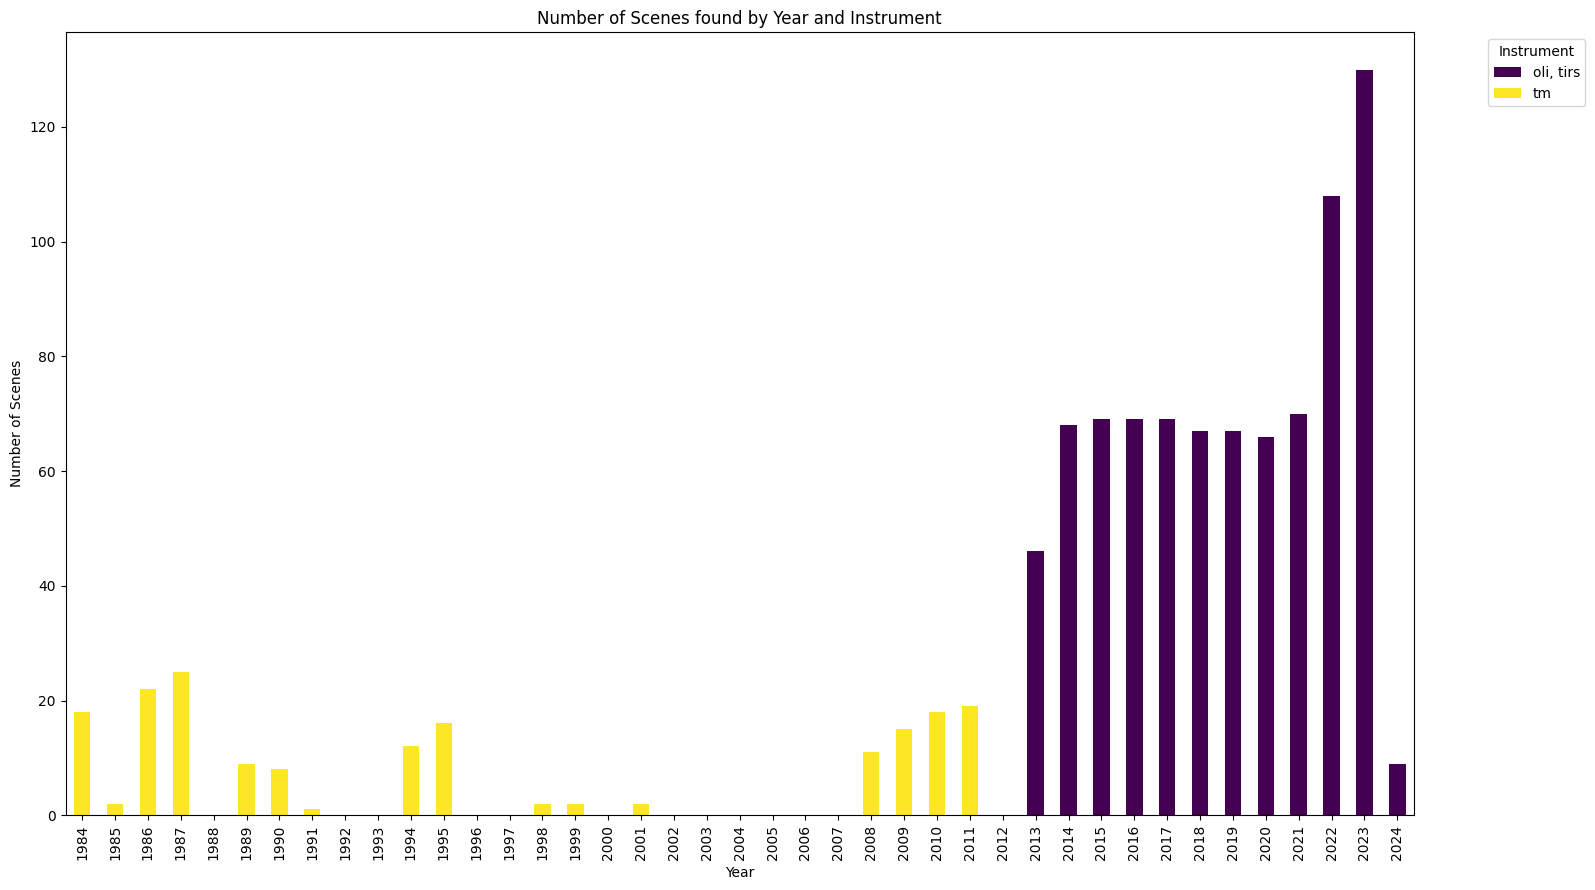

Area of interest:     knp_boundary_1.shp
Start year:           1982
End year:             2024

Directories
base directory:       \\ites-sr.ethz.ch\Satellites\Hiwi_23_TimckeFinn\Landsat-composites
shapefile directory:  \\ites-sr.ethz.ch\Satellites\Hiwi_23_TimckeFinn\Landsat-composites\shapefiles

Outputs:
geotiff          :     \\ites-sr.ethz.ch\Satellites\Hiwi_23_TimckeFinn\Landsat-composites\outputs\knp_boundary_1\geotiff
metadata :             \\ites-sr.ethz.ch\Satellites\Hiwi_23_TimckeFinn\Landsat-composites\outputs\knp_boundary_1\metadata
HTML reports:          \\ites-sr.ethz.ch\Satellites\Hiwi_23_TimckeFinn\Landsat-composites\outputs\knp_boundary_1\html
plots:                 \\ites-sr.ethz.ch\Satellites\Hiwi_23_TimckeFinn\Landsat-composites\outputs\knp_boundary_1\plots

EOdal will extract data for 28 time intervals and aggragate the scenes to one composite



In [6]:
## prepare the EOdal Mapper 
metadata_filters = [Filter('eo:cloud_cover', '<=', max_cc)]

for s in excluded_sensor:
    metadata_filters = metadata_filters + [Filter('instruments', '!=', s)]

# set directories and create new folders
base_dir: Path = Path('./')
shapefiles_dir: Path = Path(base_dir.joinpath("shapefiles")) # replace "shapefiles" with the actual folder where the shapefiles are located

aoi_folder = shapefile_name[:-4]

# Check if the folder already exists
if not os.path.exists(f'outputs/{aoi_folder}'):
    
    # If it doesn't exist, create the folder
    os.makedirs(f'outputs/{aoi_folder}')
    os.makedirs(f'outputs/{aoi_folder}/geotiff')
    os.makedirs(f'outputs/{aoi_folder}/metadata')
    os.makedirs(f'outputs/{aoi_folder}/html')
    os.makedirs(f'outputs/{aoi_folder}/plots')
    
output_dir: Path = Path(base_dir.joinpath(f'outputs/{aoi_folder}')) # replace  with the actual folder where you want to save all the different outputs
output_geotiff_dir: Path = Path(output_dir.joinpath("geotiff")) # replace with the actual folder where you want to save the geotiff
output_metadata_dir: Path = Path(output_dir.joinpath("metadata")) # replace with the actual folder where you want to save the metadata
output_html_dir: Path = Path(output_dir.joinpath("html")) # replace with the actual folder where you want to save the HTML
output_plots_dir: Path = Path(output_dir.joinpath("plots")) # replace with the actual folder where you want to save the geotiff

# setting up the EOdal Mapper
Settings = get_settings()

# Increase the maximum item number if the limit is reached: mapper.metadata.shape[0]
Settings.MAX_ITEMS  = 3000

# we use STAC, i.e., Microsoft Planetary Computer
Settings.USE_STAC = True

# -------------------------- Collection -------------------------------
collection = 'landsat-c2-l2'

# ---------------------- Spatial Feature  ------------------------------
geom: Path = Path(shapefiles_dir.joinpath(shapefile_name))
feature = Feature.from_geoseries(gpd.read_file(geom).dissolve().geometry)

# ------------------------- Time Range ---------------------------------
time_start = datetime(year_start, 1, 1)
time_end = datetime(year_end, 12, 31)

# set up the Mapper configuration
mapper_configs = MapperConfigs(
    metadata_filters=metadata_filters,
    collection=collection,
    feature=feature,
    time_start=time_start,
    time_end=time_end)

# get a new mapper instance
mapper = Mapper(mapper_configs)

# query the collection for all scenes in the time range
mapper.query_scenes()

print(f'Number of Landsat scenes found for the entire time periode {year_start}-{year_end}: {mapper.metadata.shape[0]}')

# the metadata is stored as a GeoDataFrame "mapper.metadata"
# create copy to plot it
metadata_gdf = mapper.metadata

# Convert the 'timestamp' column to timezone-unaware datetimes
metadata_gdf['sensing_time'] = metadata_gdf['sensing_time'].dt.tz_localize(None)

# Save metadata as xlsx-file
output_file_path = output_metadata_dir.joinpath(f'scenes_metadata_{shapefile_name[:-4]}_{year_start}-{year_end}.xlsx')
metadata_gdf.to_excel(output_file_path, index=True)

# Assuming metadata_gdf is defined somewhere in your code
# Call the function with the appropriate parameters
plot_geo_barplot(metadata_gdf, save_path=f'{output_plots_dir}\scenes_{year_start}_{year_end}.png')

# prints the directories and output locations
print('Area of interest:    ', shapefile_name)
print('Start year:          ', year_start)
print('End year:            ', year_end)
print()
print('Directories')
print('base directory:      ', base_dir.resolve())
print('shapefile directory: ', shapefiles_dir.resolve())
print()
print('Outputs:' )
print('geotiff          :    ', output_geotiff_dir.resolve())
print('metadata :            ', output_metadata_dir.resolve())
print('HTML reports:         ', output_html_dir.resolve())
print('plots:                ', output_plots_dir.resolve())
print()

# Plot the temporal distribution of all acquisitions and highlight those within the months of interest
# Extracting year from the 'sensing_date' column
metadata_gdf['year'] = pd.to_datetime(metadata_gdf['sensing_date']).dt.year

# Get a list of all unique years in the dataset
years_with_scenes = list(metadata_gdf['year'].unique())
#print(f'years_with_scenes: {years_with_scenes}')

# Get a list of years without scenes
years_without_scenes = [year for year in range(min(years_with_scenes), max(years_with_scenes) + 1) if year not in years_with_scenes]
#print(f'years_without_scenes: {years_without_scenes}')

print(f'EOdal will extract data for {len(years_with_scenes)} time intervals and aggragate the scenes to one composite')
print()

#reset metadata_gdf
metadata_gdf = gpd.GeoDataFrame()


# Start Extraction

Time interval 1: Number of Landsat scenes found in year 1984: 18 


C:\Users\ftimcke\AppData\Local\Temp\ipykernel_42780\1033606966.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


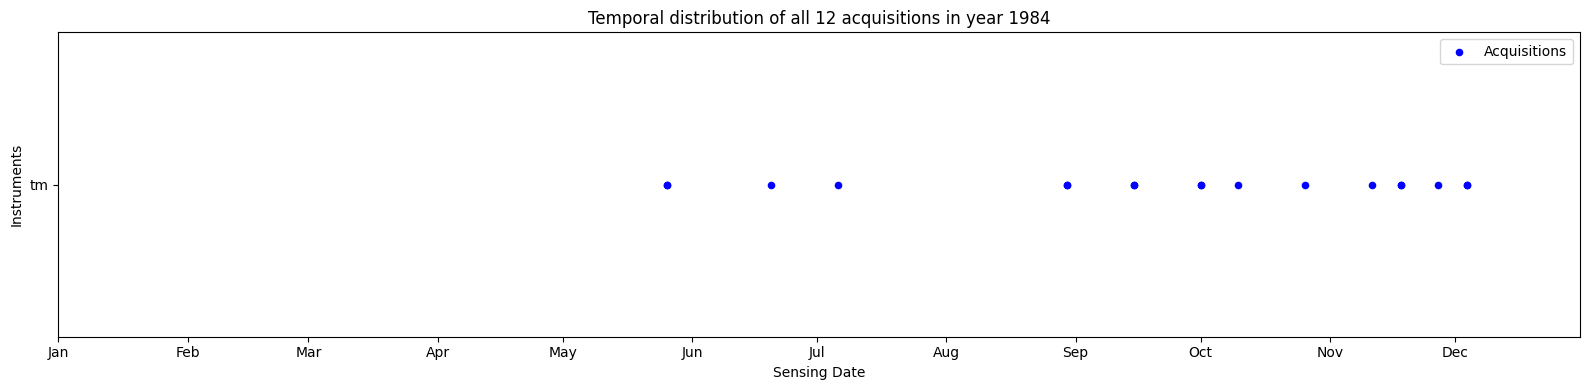

2024-01-30 14:38:21,723 eodal        INFO     Starting extraction of landsat scenes


In [7]:

# Extraction of scenes per time interval and Composite generation
# make sure that there is at least one scene within time_start and time_end, otherwise the code will crash.

for i, year in enumerate(years_with_scenes):
    
    time_start = datetime(year, 1, 1)
    time_end = datetime(year, 12, 31)

    # set up the Mapper configuration
    mapper_configs = MapperConfigs(
        metadata_filters=metadata_filters,
        collection=collection,
        feature=feature,
        time_start=time_start,
        time_end=time_end)

    # get a new mapper instance
    mapper = Mapper(mapper_configs)
    mapper.query_scenes()
    
    print(f'Time interval {i+1}: Number of Landsat scenes found in year {year}: {mapper.metadata.shape[0]} ')
    
    # the metadata is stored as a GeoDataFrame "mapper.metadata"
    # create copy to plot it
    metadata_gdf = mapper.metadata

    # Call the function with the appropriate parameters
    scatterplot_temporal_distribution(metadata_gdf, save_path=f'{output_plots_dir}\Aquisitions_{year}.png', year=year)
    
    # Convert the 'timestamp' column to timezone-unaware datetimes
    metadata_gdf['sensing_time'] = metadata_gdf['sensing_time'].dt.tz_localize(None)

    # Save metadata as an Excel file
    metadata_gdf.to_excel(output_metadata_dir.joinpath(f'scenes_{year}_metadata.xlsx'), index=True)

    # We tell EOdal how to load the Landsat scenes using `Landsat.from_usgs`and pass on some kwargs, e.g., the selection of bands we want to read. 
    # In addition, we tell EOdal to mask out clouds and shadows and the fly while reading the data using the qa_pixel band (therefore, we set the `read_qa` flag to True.
    scene_kwargs = {
        'scene_constructor': Landsat.from_usgs,
        'scene_constructor_kwargs': {
            'band_selection': ['blue', 'green', 'red', 'nir08', 'swir16', 'swir22'],
            'read_qa': True},
        'scene_modifier': prepocess_landsat_scene,
        'scene_modifier_kwargs': {}
        }

    # now we load the scenes
    mapper.load_scenes(scene_kwargs=scene_kwargs)

    # the scenes are now loaded into a EOdal SceneCollection object named "mapper.data"

    # all scenes have the same shape, i.e., the same number of bands, rows and columns
    shapes = [{timestamp: scene.get_values().shape} for timestamp, scene in mapper.data]

    #The mapper returns the single scenes. As we told the EOdal to mask out clouds, a significant share if the pixels is masked out. We will aggregate them in the next step.
    #f = mapper.data.plot(band_selection=['red', 'green', 'blue'], figsize=(10, 20), max_scenes_in_row=3)

    # open arrays for storing the data per band
    shape = (len(mapper.data), list(shapes[0].values())[0][1], list(shapes[0].values())[0][2])
    blue = np.ma.masked_array(data=np.ndarray(shape, dtype=float), mask=False)
    red = np.zeros_like(blue)
    green = np.zeros_like(blue)
    nir08 = np.zeros_like(blue)
    swir16 = np.zeros_like(blue)
    swir22 = np.zeros_like(blue)

    scene_count = np.zeros_like(blue)

    # Next, we loop over the scenes.

    # loop over scenes and store values
    idx = 0
    for _, scene in mapper.data:
        blue[idx, :, :] = scene['blue'].values
        red[idx, :, :] = scene['red'].values
        green[idx, :, :] = scene['green'].values
        nir08[idx, :, :] = scene['nir08'].values
        swir16[idx, :, :] = scene['swir16'].values
        swir22[idx, :, :] = scene['swir22'].values
        idx += 1
        
    # Finally, we aggregate the data using the median reflectance. 
    # Since we deal with masked arrays, we have to call [numpy.ma.median](https://numpy.org/doc/stable/reference/generated/numpy.ma.median.html) instead of the "normal" numpy.median function.

    # Calculate Spectral-temporal metrics:

    # Calculate the median reflectance per spectral band
    blue_median = np.ma.median(blue, axis=0)
    green_median = np.ma.median(green, axis=0)
    red_median = np.ma.median(red, axis=0)
    nir08_median = np.ma.median(nir08, axis=0)
    swir16_median = np.ma.median(swir16, axis=0)
    swir22_median = np.ma.median(swir22, axis=0)

    # Calculate the median absolute deviation (mad) per spectral band
    # mad = np.median(abs(data - np.median(data))) (https://datagy.io/mean-absolute-deviation-python/)
    blue_mad = ((np.ma.median(np.abs(blue - np.ma.median(blue, axis=0)), axis=0)) / np.ma.median(blue, axis=0)) * 100
    green_mad = ((np.ma.median(np.abs(green - np.ma.median(green, axis=0)), axis=0)) / np.ma.median(green, axis=0)) * 100
    red_mad = ((np.ma.median(np.abs(red - np.ma.median(red, axis=0)), axis=0)) / np.ma.median(red, axis=0)) * 100
    nir08_mad = ((np.ma.median(np.abs(nir08 - np.ma.median(nir08, axis=0)), axis=0)) / np.ma.median(nir08, axis=0)) * 100
    swir16_mad = ((np.ma.median(np.abs(swir16 - np.ma.median(swir16, axis=0)), axis=0)) / np.ma.median(swir16, axis=0)) * 100
    swir22_mad = ((np.ma.median(np.abs(swir22 - np.ma.median(swir22, axis=0)), axis=0)) / np.ma.median(swir22, axis=0)) * 100

    # Calculate the mean reflectance per spectral band
    blue_mean = np.ma.mean(blue, axis=0)
    green_mean = np.ma.mean(green, axis=0)
    red_mean = np.ma.mean(red, axis=0)
    nir08_mean = np.ma.mean(nir08, axis=0)
    swir16_mean = np.ma.mean(swir16, axis=0)
    swir22_mean = np.ma.mean(swir22, axis=0)

    # Calculate the coefficient of variation (cov) per spectral band
    # cov = np.std(data) / np.mean(data) (https://datagy.io/python-coefficient-of-variation/)  
    blue_cov = (np.ma.std(blue, axis=0) / np.ma.mean(blue, axis=0)) * 100
    green_cov = (np.ma.std(green, axis=0) / np.ma.mean(green, axis=0)) * 100
    red_cov = (np.ma.std(red, axis=0) / np.ma.mean(red, axis=0)) * 100
    nir08_cov = (np.ma.std(nir08, axis=0) / np.ma.mean(nir08, axis=0)) * 100
    swir16_cov = (np.ma.std(swir16, axis=0) / np.ma.mean(swir16, axis=0)) * 100
    swir22_cov = (np.ma.std(swir22, axis=0) / np.ma.mean(swir22, axis=0)) * 100

    # Calculate the difference between mean and median, also known as skewness or skew per spectral band
    # skew = np.mean(data) - np.median(data) https://www.turing.com/kb/calculating-skewness-and-kurtosis-in-python#skewness  
    blue_skew = np.ma.mean(blue, axis=0) - np.ma.median(blue, axis=0)
    green_skew = np.ma.mean(green, axis=0) - np.ma.median(green, axis=0)
    red_skew = np.ma.mean(red, axis=0) - np.ma.median(red, axis=0)
    nir08_skew = np.ma.mean(nir08, axis=0) - np.ma.median(nir08, axis=0)
    swir16_skew = np.ma.mean(swir16, axis=0) - np.ma.median(swir16, axis=0)
    swir22_skew = np.ma.mean(swir22, axis=0) - np.ma.median(swir22, axis=0)

    # calculate the pixel count (e.g. for the blue band)
    scene_count = np.ma.count(blue, axis=0)

    # We store the results in a new RasterCollection.

    ## Create new dictionaries for the metrics bands:
    # median bands (changed the order of the first 3 bands from Landsats default order to match RGB when displayed in ArcGIS Pro)
    median_bands = {'red': red_median, 
                    'green': green_median,
                    'blue': blue_median, 
                    'nir08': nir08_median,
                    'swir16' : swir16_median,
                    'swir22' : swir22_median}

    # mad bands
    mad_bands = {'blue': blue_mad, 
                'green': green_mad, 
                'red': red_mad, 
                'nir08': nir08_mad,
                'swir16' : swir16_mad,
                'swir22' : swir22_mad}

    # mean bands
    mean_bands = {'blue': blue_mean, 
                    'green': green_mean, 
                    'red': red_mean, 
                    'nir08': nir08_mean,
                    'swir16' : swir16_mean,
                    'swir22' : swir22_mean}

    # cov bands
    cov_bands = {'blue': blue_cov, 
                    'green': green_cov, 
                    'red': red_cov, 
                    'nir08': nir08_cov,
                    'swir16' : swir16_cov,
                    'swir22' : swir22_cov}

    # skew bands
    skew_bands = {'blue': blue_skew, 
                    'green': green_skew, 
                    'red': red_skew, 
                    'nir08': nir08_skew,
                    'swir16' : swir16_skew,
                    'swir22' : swir22_skew}

    ## Create new RasterCollection rc:
    rc = RasterCollection()

    ### add bands to RasterCollection rc as new bands:
    # add median bands to rc
    for band_name, band_value in median_bands.items():
        rc.add_band(
            band_constructor=Band,
            values=band_value,
            band_name=f'{band_name}_median',
            geo_info=scene[band_name].geo_info)
        
    # add mad bands to rc
    for band_name, band_value in mad_bands.items():
        rc.add_band(
            band_constructor=Band,
            values=band_value,
            band_name=f'{band_name}_mad',
            geo_info=scene[band_name].geo_info)

    # add mean bands to rc
    for band_name, band_value in mean_bands.items():
        rc.add_band(
            band_constructor=Band,
            values=band_value,
            band_name=f'{band_name}_mean',
            geo_info=scene[band_name].geo_info)
        
    # add cov bands to rc
    for band_name, band_value in cov_bands.items():
        rc.add_band(
            band_constructor=Band,
            values=band_value,
            band_name=f'{band_name}_cov',
            geo_info=scene[band_name].geo_info)
        
    # add skew bands to rc
    for band_name, band_value in skew_bands.items():
        rc.add_band(
            band_constructor=Band,
            values=band_value,
            band_name=f'{band_name}_skew',
            geo_info=scene[band_name].geo_info)
        
    # add pixel count to rc as new band
    rc.add_band(
            band_constructor=Band,
            values=scene_count,
            band_name='scene_count',
            geo_info=scene['blue'].geo_info)

    # add band aliases to the band names, which are used in the calculation of the spectral indices
    rc._band_aliases = ['red', 'green', 'blue', 'nir_1', 'swir_1', 'swir_2',
                        'blue_mad', 'green_mad', 'red_mad', 'nir08_mad', 'swir16_mad', 'swir22_mad', 
                        'blue_mean', 'green_mean', 'red_mean', 'nir08_mean', 'swir16_mean', 'swir22_mean', 
                        'blue_cov', 'green_cov', 'red_cov', 'nir08_cov', 'swir16_cov', 'swir22_cov', 
                        'blue_skew', 'green_skew', 'red_skew', 'nir08_skew', 'swir16_skew', 'swir22_skew', 
                        'scene_count'] + spectral_indices

    # calculate some SI
    for index in spectral_indices:
        rc.calc_si(index, inplace = True)

    # reset to original band aliases
    rc._band_aliases = ['red_median', 'green_median', 'blue_median', 'nir08_median', 'swir16_median', 'swir22_median',
                        'blue_mad', 'green_mad', 'red_mad', 'nir08_mad', 'swir16_mad', 'swir22_mad', 
                        'blue_mean', 'green_mean', 'red_mean', 'nir08_mean', 'swir16_mean', 'swir22_mean', 
                        'blue_cov', 'green_cov', 'red_cov', 'nir08_cov', 'swir16_cov', 'swir22_cov', 
                        'blue_skew', 'green_skew', 'red_skew', 'nir08_skew', 'swir16_skew', 'swir22_skew', 
                        'scene_count'] + spectral_indices


    # save as GeoTiff 
    rc.to_rasterio(f'S:\Hiwi_23_TimckeFinn\Landsat-composites\{output_geotiff_dir}\Landsat_Composite_{year}.tif')
    print(f'GeoTiff saved at: S:\Hiwi_23_TimckeFinn\Landsat-composites\{output_geotiff_dir}\Landsat_Composite_{year}.tif')
    ### clean the GeoTiff 
    # replace high fillvalues with NaN in the raster to make it readable by ArcGIS Pro


    # Define input and output paths for TIFF files
    input_tif_path = f'S:\Hiwi_23_TimckeFinn\Landsat-composites\{output_geotiff_dir}\Landsat_Composite_{year}.tif'
    output_tif_path = f'S:\Hiwi_23_TimckeFinn\Landsat-composites\{output_geotiff_dir}\Landsat_Composite_{year}_cleaned.tif'

    # Open the TIFF file using rasterio
    with rasterio.open(input_tif_path) as src:
        # Read all bands of the raster data
        raster_data = src.read()

        # Replace specific values (e.g., 1e+20) with NaN for each band
        replaced_data = np.where(raster_data == 1e+20, np.nan, raster_data)

        # Create a new raster file with NaN values
        with rasterio.open(
            output_tif_path,
            'w',
            driver='GTiff',
            height=src.height,
            width=src.width,
            count=src.count,  # Number of bands
            dtype=replaced_data.dtype,
            crs=src.crs,
            transform=src.transform,
        ) as dst:
            dst.write(replaced_data)

    # Remove the original input TIFF file
    os.remove(input_tif_path)

    # Initialize a RasterCollection from the cleaned TIFF file
    rc_clean = RasterCollection.from_multi_band_raster(fpath_raster=output_tif_path)

    # Set band aliases for the RasterCollection
    rc_clean._band_aliases = ['red_median', 'green_median', 'blue_median', 'nir08_median', 'swir16_median', 'swir22_median',
                        'blue_mad', 'green_mad', 'red_mad', 'nir08_mad', 'swir16_mad', 'swir22_mad', 
                        'blue_mean', 'green_mean', 'red_mean', 'nir08_mean', 'swir16_mean', 'swir22_mean', 
                        'blue_cov', 'green_cov', 'red_cov', 'nir08_cov', 'swir16_cov', 'swir22_cov', 
                        'blue_skew', 'green_skew', 'red_skew', 'nir08_skew', 'swir16_skew', 'swir22_skew', 
                        'scene_count'] + spectral_indices

    # Save the RasterCollection to a new GeoTIFF file
    rc_clean.to_rasterio(f'S:\Hiwi_23_TimckeFinn\Landsat-composites\{output_geotiff_dir}\Landsat_Composite_{year}_cleaned.tif',
                        use_band_aliases=True)

    # Display a message about the saved GeoTIFF file
    print(f'GeoTiff saved at: S:\Hiwi_23_TimckeFinn\Landsat-composites\{output_geotiff_dir}\Landsat_Composite_{year}_cleaned.tif')

    # Remove the temporary cleaned TIFF file
    os.remove(output_tif_path)

    ### Generate plots of the metric bands and spectral indices ##
    # We plot the bands. As you can see, after the compositing there are still some no-data pixels left (white areas). This is because for some locations there were not enough cloud-free observations to compute the statistical measure. This is most likely due to Landsat orbit design and overpass frequency.



    # Define colormap dictionary
    colormap_dict = {
        'scene_count': "Greys_r",

        'blue_median': "Blues",
        'green_median': "Greens",
        'red_median': "Reds",
        'nir08_median': "Greys",
        'swir16_median': "Greys",
        'swir22_median': "Greys",

        'blue_mad': "Blues",
        'green_mad': "Greens",
        'red_mad': "Reds",
        'nir08_mad': "Greys",
        'swir16_mad': "Greys",
        'swir22_mad': "Greys",

        'blue_mean': "Blues",
        'green_mean': "Greens",
        'red_mean': "Reds",
        'nir08_mean': "Greys",
        'swir16_mean': "Greys",
        'swir22_mean': "Greys",

        'blue_cov': "Blues",
        'green_cov': "Greens",
        'red_cov': "Reds",
        'nir08_cov': "Greys",
        'swir16_cov': "Greys",
        'swir22_cov': "Greys",

        'blue_skew': "RdBu",
        'green_skew': "RdBu",
        'red_skew': "RdBu",
        'nir08_skew': "RdBu",
        'swir16_skew': "RdBu",
        'swir22_skew': "RdBu",

        'NDVI' : 'YlGn',
        'EVI' : 'YlGn',
        'CI_GREEN' : 'YlGn', 
        'MSAVI' : 'YlGn',
        'NDWI' : 'GnBu',
        'BSI' : 'pink_r'
    }

    # Assuming rc, rc_clean, spectral_inidices and colormap_dict are defined somewhere in your code above:
    # Call the function with the appropriate parameters, the plots will be saved in the plots folder
    plot_bands_median_mad(rc, colormap_dict, save_path=f'{output_plots_dir}\median_mad_{year}.png')
    plot_bands_mean_cov(rc, colormap_dict, save_path=f'{output_plots_dir}\mean_cov_{year}.png')
    plot_bands_skew(rc, colormap_dict, save_path=f'{output_plots_dir}\skew_{year}.png')
    plot_rgb_and_spectral_indices(rc, rc_clean, spectral_indices, colormap_dict, save_path=f'{output_plots_dir}\spectral_indices_{year}.png')
    plot_rgb_and_scene_count(rc, colormap_dict, save_path=f'{output_plots_dir}\scene_count_{year}.png')

    # HTML Report generation for a single time interval
    from jinja2 import Environment, FileSystemLoader

    # 2. Create a template Environment
    env = Environment(loader=FileSystemLoader('templates'))

    # 3. Load the template from the Environment
    template = env.get_template('report_template.html')

    # 4. Render the template with variables
    try:
        html = template.render(page_title_text=f'Landsat Composite Report',
                            title_text=f'Landsat Composite Report {year}',
                            timeinterval=f'{str(time_start)[:-9]} - {str(time_end)[:-9]}',
                            geom=geom,
                            max_cc=max_cc,
                            excluded_sensor=excluded_sensor,
                            year=year,
                            aoi_folder=aoi_folder
                            )
        
    except Exception as e:
        print(f"Error rendering template: {e}")
        # Handle the exception or exit gracefully

    # 5. Write the HTML file at the specified location
    output_path = output_html_dir / f'Landsat_Composite_Report_{year}.html'
    with open(output_path, 'w') as f:
        f.write(html)
